<a href="https://colab.research.google.com/github/yccccc12/Pneumonia_Detection/blob/main/pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Dataset & Libraries

In [1]:
import kagglehub
import os
# Download latest version
path = kagglehub.dataset_download("tolgadincer/labeled-chest-xray-images")

print("Path to dataset files:", path)
print("Dataset files:", os.listdir(path))

100%|██████████| 1.17G/1.17G [00:11<00:00, 112MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tolgadincer/labeled-chest-xray-images/versions/1
Dataset files: ['chest_xray']


In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

# Data Exploration

In [3]:
# Setting up directory
data_dir = os.path.join(path, "chest_xray")
os.listdir(data_dir)

['train', 'test']

In [4]:
# Check classes inside train and test
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
print("Train classes:", os.listdir(train_dir))
print("Test classes:", os.listdir(train_dir))

Train classes: ['PNEUMONIA', 'NORMAL']
Test classes: ['PNEUMONIA', 'NORMAL']


In [82]:
normal_train_count = len(os.listdir(os.path.join(train_dir, "NORMAL")))
pneumonia_train_count = len(os.listdir(os.path.join(train_dir, "PNEUMONIA")))

# Get counts for test
normal_test_count = len(os.listdir(os.path.join(test_dir, "NORMAL")))
pneumonia_test_count = len(os.listdir(os.path.join(test_dir, "PNEUMONIA")))

# Print summary
print("Train set")
print(f"  NORMAL: {normal_train_count}")
print(f"  PNEUMONIA: {pneumonia_train_count}")

print("\nTest set")
print(f"  NORMAL: {normal_test_count}")
print(f"  PNEUMONIA: {pneumonia_test_count}")

Train set
  NORMAL: 1349
  PNEUMONIA: 3883

Test set
  NORMAL: 234
  PNEUMONIA: 390


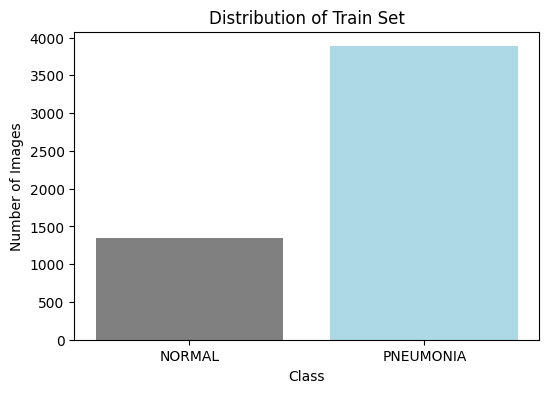

In [83]:
# Plot distribution of train set
labels = ['NORMAL', 'PNEUMONIA']
counts = [normal_train_count, pneumonia_train_count]

plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color=['gray', 'lightblue'])
plt.title('Distribution of Train Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

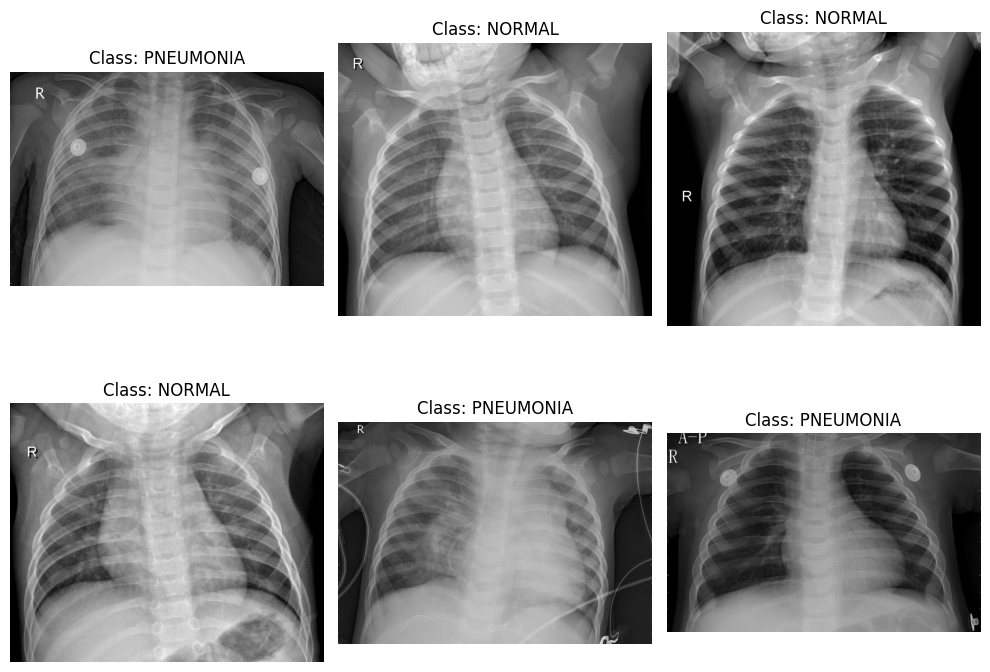

In [10]:
import random
def display_random_images(directory, num_images=6):
    classes = os.listdir(directory)
    plt.figure(figsize=(10, 8))
    for i in range(num_images):
        class_name = random.choice(classes)
        class_path = os.path.join(directory, class_name)
        image_files = os.listdir(class_path)
        image_name = random.choice(image_files)
        image_path = os.path.join(class_path, image_name)

        img = mpimg.imread(image_path)
        plt.subplot(2, 3, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Class: {class_name}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_random_images(train_dir, num_images=6)

# Preparing the Data

In [11]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHS = 1
N_CLASSES = 2

basic_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)), # maintain aspect ratio
    transforms.CenterCrop(224), # then crop to 224x224
    transforms.ToTensor(), # Automatically scaled image to [0, 1]
    transforms.Normalize(mean=[0.5], std=[0.5]) # scaled from [0, 1] -> [-1, 1]
])

class MyDataset(Dataset):
  def __init__(self, base_dir, transform):
    self.imgs = []
    self.labels = []
    self.transform = transform
    classes = sorted(os.listdir(base_dir))
    self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}

    for cls_name in classes:
      cls_dir = os.path.join(base_dir, cls_name)
      for fname in os.listdir(cls_dir):
        if fname.endswith(('.jpeg', '.png', '.jpg')):
          self.imgs.append(os.path.join(cls_dir, fname))
          self.labels.append(self.class_to_idx[cls_name])

  def __getitem__(self, idx):
    img_path = self.imgs[idx]
    label = self.labels[idx]
    image = Image.open(img_path).convert('L')
    if self.transform:
      image = self.transform(image)
    return image, torch.tensor(label).long()

  def __len__(self):
    return len(self.imgs)

# Data Augmentation

In [20]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_HEIGHT, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    transforms.RandomAutocontrast(p=0.3),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Data Loader

In [21]:
BATCH_SIZE = 32
train_data = MyDataset(train_dir, transform=train_transform)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
train_N = len(train_loader.dataset)

valid_data = MyDataset(test_dir, transform=basic_transform)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE)
valid_N = len(valid_loader.dataset)

In [22]:
batch = next(iter(train_loader))
batch

[tensor([[[[ 0.2471,  0.2706,  0.2941,  ..., -0.9294, -0.9294, -0.9294],
           [ 0.2784,  0.2941,  0.3412,  ..., -0.9294, -0.9294, -0.9294],
           [ 0.3020,  0.3569,  0.4431,  ..., -0.9294, -0.9294, -0.9294],
           ...,
           [-0.9294, -0.9294, -0.9294,  ..., -0.9294, -0.9294, -0.9294],
           [-0.9294, -0.9294, -0.9294,  ..., -0.9294, -0.9294, -0.9294],
           [-0.9294, -0.9294, -0.9294,  ..., -0.9294, -0.9294, -0.9294]]],
 
 
         [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           ...,
           [-1.0000, -1.0000, -1.0000,  ..., -0.7725, -0.9608, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -0.8588, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -0.8588, -1.0000, -1.0000]]],
 
 
         [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
       

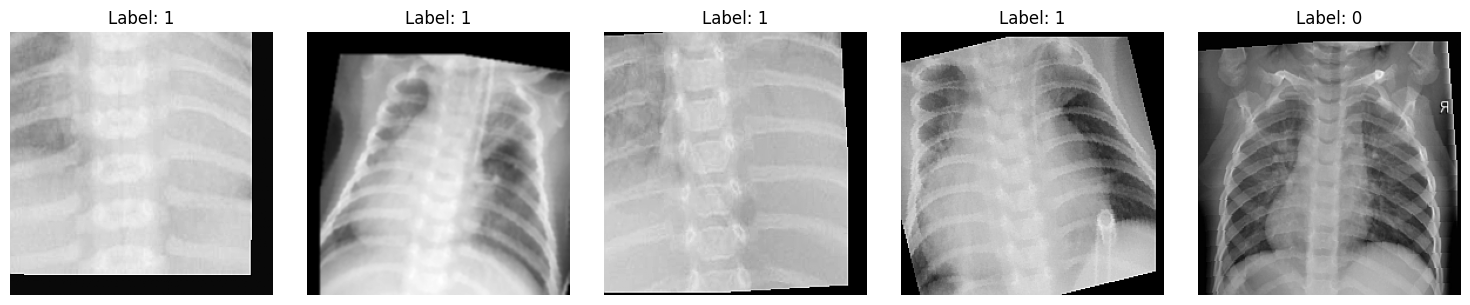

In [23]:
# Visualize the first 5 images in the batch
# label 0 -> NORMAL
# label 1 -> PNEUMONIA
images, labels = batch
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
  axes[i].imshow(images[i].squeeze().numpy(), cmap='gray')
  axes[i].set_title(f'Label: {labels[i].item()}')
  axes[i].axis('off')

plt.tight_layout()
plt.show()

In [24]:
print(batch[0].shape)
print(batch[1].shape)

torch.Size([32, 1, 224, 224])
torch.Size([32])


# Training Model

In [26]:
# Function use to train the model
def train_model(model, epochs=10, patience=5, save_path="model.pth"):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_loss = float('inf')
    counter = 0

    for epoch in range(epochs):
        # Train
        model.train()
        total_loss, correct, total = 0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * xb.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

        avg_train_loss = total_loss / total
        train_acc = correct / total
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        total_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for xb, yb in valid_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                loss = criterion(outputs, yb)
                total_loss += loss.item() * xb.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)

        avg_val_loss = total_loss / total
        val_acc = correct / total
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)


        print(f"Epoch {epoch+1}: "
              f"Train loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            torch.save(model.state_dict(), save_path)
            print("✅ Saved new best model")
        else:
            counter += 1
            print(f"⏳ EarlyStopping counter: {counter}/{patience}")
            if counter >= patience:
                print("⛔ Early stopping triggered")
                break

    return train_losses, val_losses, train_accs, val_accs


In [28]:
# Plot the Loss & Accuracy Curve
def plot_history_dict(history, title="Model Performance"):
    train_losses = history[0]
    val_losses   = history[1]
    train_accs   = history[2]
    val_accs     = history[3]

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Val Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_accs, label='Train Acc', marker='o')
    plt.plot(val_accs, label='Val Acc', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.suptitle(title)
    plt.show()

In [46]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, data_loader, class_names, title='Confusion Matrix'):
    """
    Plots the confusion matrix for a given model and data loader.

    Args:
        model: Trained PyTorch model.
        data_loader: DataLoader for validation or test set.
        class_names: List of class names (strings).
        title: Title for the plot.
    """
    model = model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# 2-layer CNN

In [25]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(IMG_CHS, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        flatten_size = 64 * (IMG_HEIGHT // 4) * (IMG_WIDTH // 4)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flatten_size, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

In [27]:
history_cnn2 = train_model(CNN2(), save_path="cnn2.pth")

Epoch 1: Train loss: 0.5239, Acc: 0.7903 | Val loss: 0.3670, Acc: 0.8494
✅ Saved new best model
Epoch 2: Train loss: 0.3033, Acc: 0.8672 | Val loss: 0.3599, Acc: 0.8686
✅ Saved new best model
Epoch 3: Train loss: 0.2716, Acc: 0.8891 | Val loss: 0.3133, Acc: 0.8766
✅ Saved new best model
Epoch 4: Train loss: 0.2553, Acc: 0.8922 | Val loss: 0.2830, Acc: 0.8798
✅ Saved new best model
Epoch 5: Train loss: 0.2343, Acc: 0.9046 | Val loss: 0.2591, Acc: 0.9071
✅ Saved new best model
Epoch 6: Train loss: 0.2259, Acc: 0.9094 | Val loss: 0.2650, Acc: 0.8894
⏳ EarlyStopping counter: 1/5
Epoch 7: Train loss: 0.2160, Acc: 0.9144 | Val loss: 0.2559, Acc: 0.8942
✅ Saved new best model
Epoch 8: Train loss: 0.2113, Acc: 0.9155 | Val loss: 0.2393, Acc: 0.8990
✅ Saved new best model
Epoch 9: Train loss: 0.2099, Acc: 0.9182 | Val loss: 0.2730, Acc: 0.9054
⏳ EarlyStopping counter: 1/5
Epoch 10: Train loss: 0.2025, Acc: 0.9224 | Val loss: 0.2390, Acc: 0.9006
✅ Saved new best model


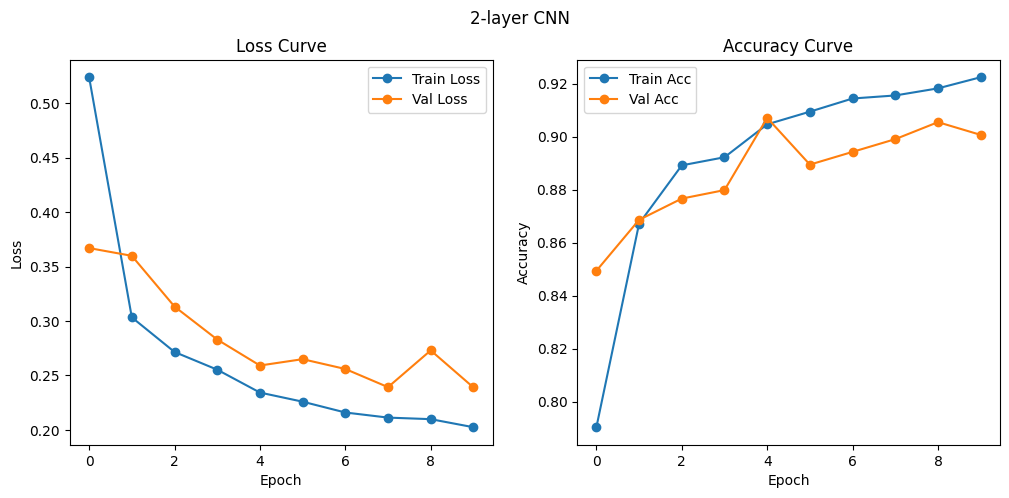

In [29]:
plot_history_dict(history_cnn2, title="2-layer CNN")

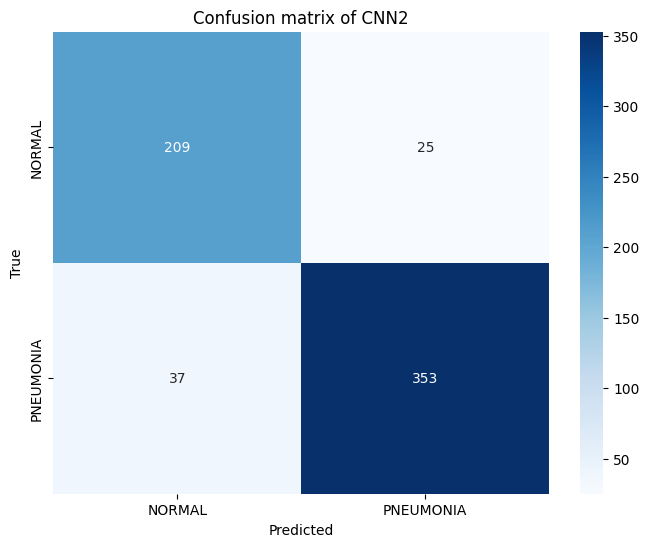

In [68]:
# Instantiate model and load weights
CNN2 = CNN2()
CNN2.load_state_dict(torch.load('cnn2.pth'))

# class names
class_names = list(valid_data.class_to_idx.keys())

plot_confusion_matrix(CNN2, valid_loader, class_names, title="Confusion matrix of CNN2")


# 2-layer CNN + Batch Normalization + Dropout

In [30]:
class CNN2_BN_D(nn.Module):
    def __init__(self):
        super(CNN2_BN_D, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(IMG_CHS, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        flatten_size = 64 * (IMG_HEIGHT // 4) * (IMG_WIDTH // 4)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flatten_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

In [32]:
history_cnn2_bn_d = train_model(CNN2_BN_D(), save_path="cnn2_bn_d.pth")

Epoch 1: Train loss: 1.5891, Acc: 0.7429 | Val loss: 0.4648, Acc: 0.6250
✅ Saved new best model
Epoch 2: Train loss: 0.3668, Acc: 0.8299 | Val loss: 0.4228, Acc: 0.9135
✅ Saved new best model
Epoch 3: Train loss: 0.3421, Acc: 0.8530 | Val loss: 0.3817, Acc: 0.9183
✅ Saved new best model
Epoch 4: Train loss: 0.3222, Acc: 0.8641 | Val loss: 0.4665, Acc: 0.7869
⏳ EarlyStopping counter: 1/5
Epoch 5: Train loss: 0.3181, Acc: 0.8618 | Val loss: 0.4119, Acc: 0.8478
⏳ EarlyStopping counter: 2/5
Epoch 6: Train loss: 0.2956, Acc: 0.8813 | Val loss: 0.4685, Acc: 0.7676
⏳ EarlyStopping counter: 3/5
Epoch 7: Train loss: 0.2887, Acc: 0.8849 | Val loss: 0.3393, Acc: 0.9071
✅ Saved new best model
Epoch 8: Train loss: 0.2888, Acc: 0.8817 | Val loss: 0.3329, Acc: 0.9071
✅ Saved new best model
Epoch 9: Train loss: 0.2671, Acc: 0.9000 | Val loss: 0.3751, Acc: 0.8558
⏳ EarlyStopping counter: 1/5
Epoch 10: Train loss: 0.2834, Acc: 0.8869 | Val loss: 0.3726, Acc: 0.8574
⏳ EarlyStopping counter: 2/5


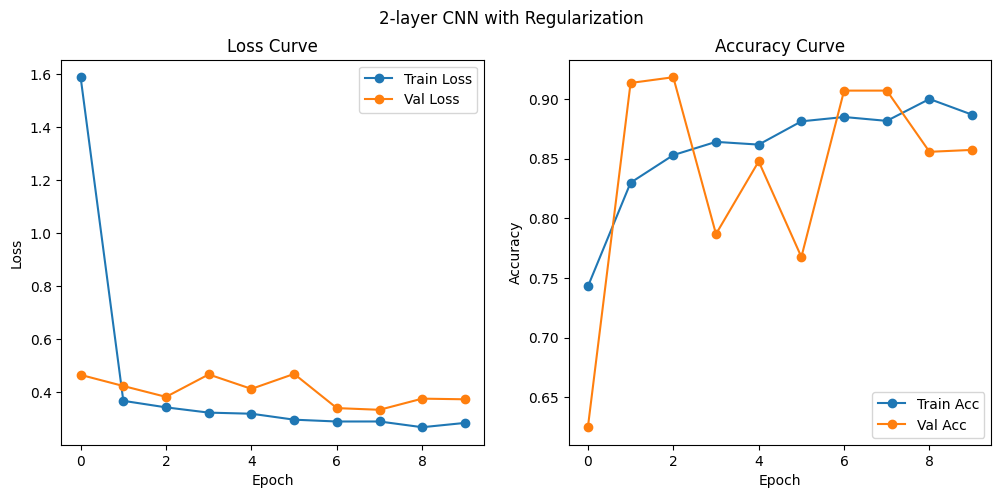

In [33]:
plot_history_dict(history_cnn2_bn_d, title="2-layer CNN with Regularization")

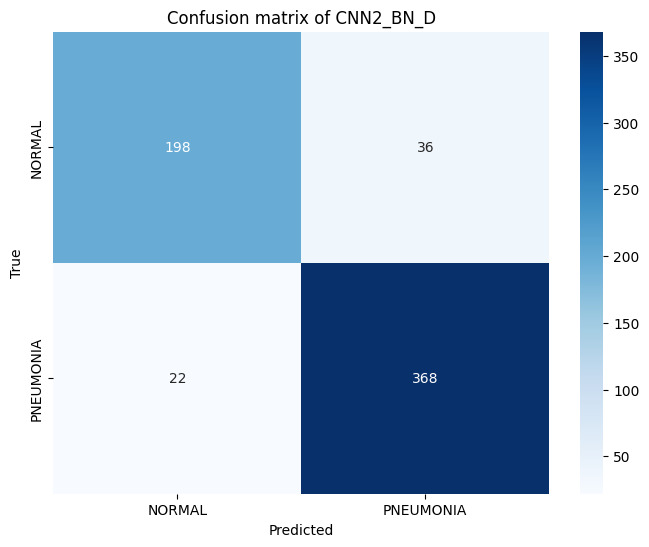

In [69]:
CNN2_BN_D = CNN2_BN_D()
CNN2_BN_D.load_state_dict(torch.load('cnn2_bn_d.pth'))

plot_confusion_matrix(CNN2_BN_D, valid_loader, class_names, title="Confusion matrix of CNN2_BN_D")


# 3-layer CNN + Batch Normalization + Droput

In [50]:
class CNN3_BN_D(nn.Module):
    def __init__(self):
        super(CNN3_BN_D, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(IMG_CHS, 32, 3, padding=1),
            nn.BatchNorm2d(32), # new added
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64), # new added
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        flatten_size = 128 * (IMG_HEIGHT // 8) * (IMG_WIDTH // 8)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flatten_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, N_CLASSES)
        )

    def forward(self, x):
        return self.classifier(self.features(x))


In [51]:
history_cnn3_bn_d = train_model(CNN3_BN_D(), save_path="cnn3_bn_d.pth")

Epoch 1: Train loss: 1.7677, Acc: 0.8073 | Val loss: 0.3760, Acc: 0.8478
✅ Saved new best model
Epoch 2: Train loss: 0.3007, Acc: 0.8702 | Val loss: 0.2590, Acc: 0.9006
✅ Saved new best model
Epoch 3: Train loss: 0.2509, Acc: 0.8958 | Val loss: 0.2687, Acc: 0.8958
⏳ EarlyStopping counter: 1/5
Epoch 4: Train loss: 0.2520, Acc: 0.9021 | Val loss: 0.7432, Acc: 0.6651
⏳ EarlyStopping counter: 2/5
Epoch 5: Train loss: 0.2422, Acc: 0.9018 | Val loss: 0.5472, Acc: 0.8397
⏳ EarlyStopping counter: 3/5
Epoch 6: Train loss: 0.2354, Acc: 0.9058 | Val loss: 0.5068, Acc: 0.7740
⏳ EarlyStopping counter: 4/5
Epoch 7: Train loss: 0.2353, Acc: 0.9056 | Val loss: 0.3239, Acc: 0.8542
⏳ EarlyStopping counter: 5/5
⛔ Early stopping triggered


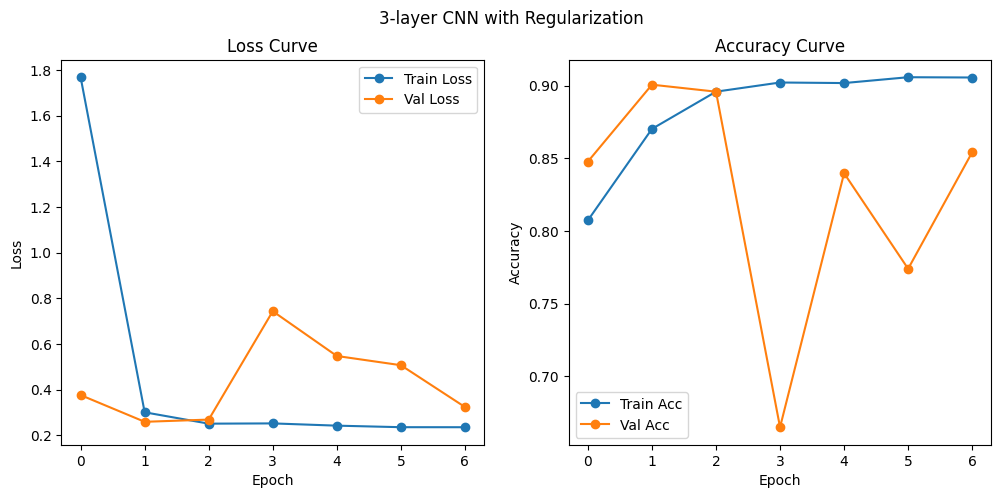

In [52]:
plot_history_dict(history_cnn3_bn_d, title="3-layer CNN with Regularization")

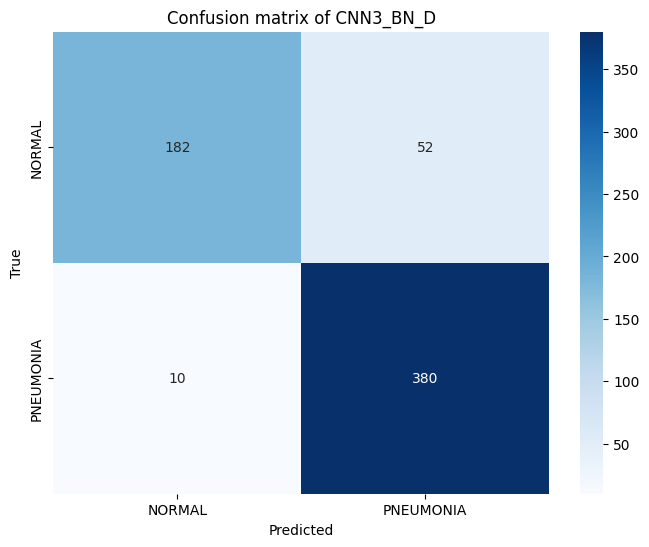

In [70]:
CNN3_BN_D = CNN3_BN_D()
CNN3_BN_D.load_state_dict(torch.load('cnn3_bn_d.pth'))

plot_confusion_matrix(CNN3_BN_D, valid_loader, class_names, title="Confusion matrix of CNN3_BN_D")


# Pretrained model

In [61]:
import torchvision.models as models

pre_model = models.resnet18(pretrained=True)
pre_model.conv1 = nn.Conv2d(IMG_CHS, 64, kernel_size=7, stride=2, padding=3, bias=False)

with torch.no_grad():
    pre_model.conv1.weight = nn.Parameter(pre_model.conv1.weight.mean(dim=1, keepdim=True))

# Change output to match number of classes
num_ftrs = pre_model.fc.in_features
pre_model.fc = nn.Linear(num_ftrs, len(class_names))

pre_model = pre_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pre_model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)


# Early stopping params
patience = 5
best_val_loss = float('inf')
patience_counter = 0
model_path = "pretrained_model.pth"

# Training Loop
num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    pre_model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = pre_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total
    train_losses.append(train_loss)

    # Validation
    pre_model.eval()
    val_loss = 0.0
    val_correct, val_total = 0, 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = pre_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(valid_loader.dataset)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)

    # Scheduler step
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}: "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(pre_model.state_dict(), model_path)
        print("✅ Saved new best model")
    else:
        patience_counter += 1
        print(f"⏳ EarlyStopping counter: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("⛔ Early stopping triggered!")
            break


Epoch 1: Train Loss: 0.1861, Acc: 0.9281 | Val Loss: 0.2410, Acc: 0.9247
✅ Saved new best model
Epoch 2: Train Loss: 0.1220, Acc: 0.9534 | Val Loss: 0.1411, Acc: 0.9359
✅ Saved new best model
Epoch 3: Train Loss: 0.1104, Acc: 0.9597 | Val Loss: 0.2003, Acc: 0.9311
⏳ EarlyStopping counter: 1/5
Epoch 4: Train Loss: 0.0982, Acc: 0.9620 | Val Loss: 0.0907, Acc: 0.9712
✅ Saved new best model
Epoch 5: Train Loss: 0.0880, Acc: 0.9669 | Val Loss: 0.1238, Acc: 0.9519
⏳ EarlyStopping counter: 1/5
Epoch 6: Train Loss: 0.0788, Acc: 0.9729 | Val Loss: 0.1416, Acc: 0.9455
⏳ EarlyStopping counter: 2/5
Epoch 7: Train Loss: 0.0695, Acc: 0.9738 | Val Loss: 0.1050, Acc: 0.9599
⏳ EarlyStopping counter: 3/5
Epoch 8: Train Loss: 0.0575, Acc: 0.9799 | Val Loss: 0.1360, Acc: 0.9471
⏳ EarlyStopping counter: 4/5
Epoch 9: Train Loss: 0.0481, Acc: 0.9801 | Val Loss: 0.1048, Acc: 0.9551
⏳ EarlyStopping counter: 5/5
⛔ Early stopping triggered!


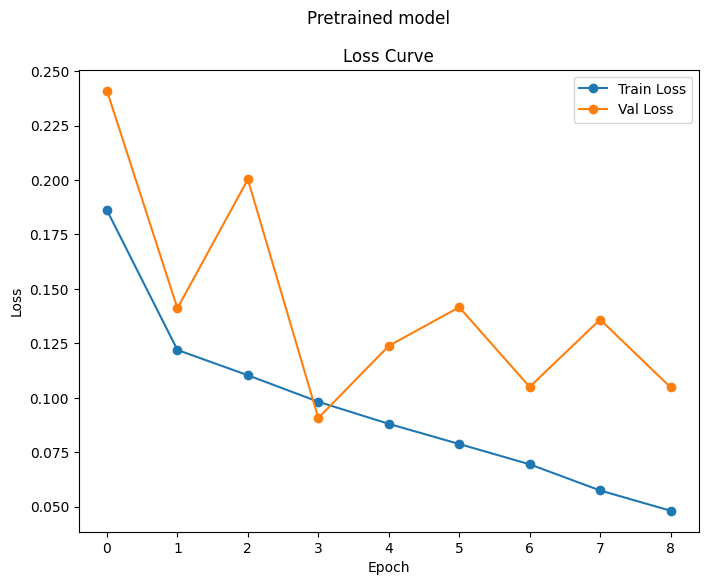

In [66]:
plt.figure(figsize=(8,6))

plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.suptitle("Pretrained model")
plt.show()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


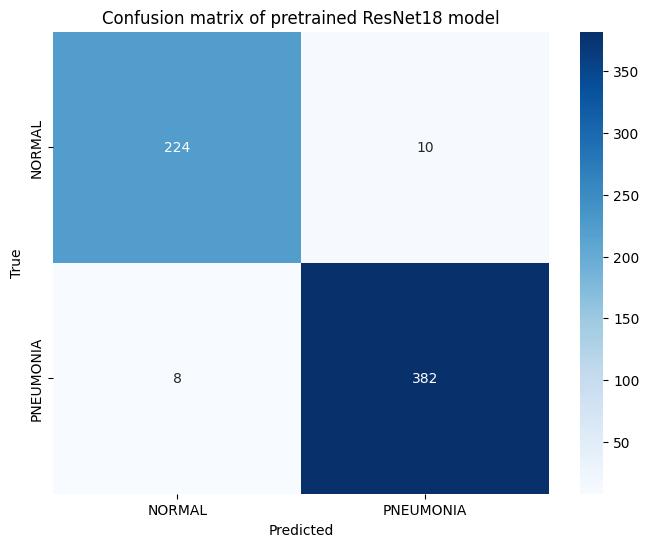

In [72]:
# Rebuild the same architecture
pre_RESNET18 = models.resnet18(pretrained=False)
pre_RESNET18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
pre_RESNET18.fc = nn.Linear(pre_RESNET18.fc.in_features, len(class_names))

# Load your trained weights
pre_RESNET18.load_state_dict(torch.load('pretrained_model.pth'))
pre_RESNET18 = pre_RESNET18.to(device)
pre_RESNET18.eval()

# Now plot confusion matrix
plot_confusion_matrix(pre_RESNET18, valid_loader, class_names, title="Confusion matrix of pretrained ResNet18 model")


# Model Comparison & Selection

In [67]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model_metrics(model, data_loader, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    return acc, precision, recall, f1


In [73]:
results = []

for name, model in zip(
    ["CNN2", "CNN2_BN_D", "CNN3_BN_D", "pretrained_model"],
    [CNN2, CNN2_BN_D, CNN3_BN_D, pre_RESNET18]
):
    acc, precision, recall, f1 = evaluate_model_metrics(model, valid_loader, device)
    results.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1 Score": round(f1, 4)
    })

df_results = pd.DataFrame(results)
df_results

,Model,Accuracy,Precision,Recall,F1 Score
0,CNN2,0.9006,0.9023,0.9006,0.9011
1,CNN2_BN_D,0.9071,0.9068,0.9071,0.9064
2,CNN3_BN_D,0.9006,0.9052,0.9006,0.8983
3,pretrained_model,0.9712,0.9711,0.9712,0.9711


- Based on the table, pretrained_model having the out-performed matrix comapared to other model
- The pretrained model being used is restnet18
- So, our final model is 'pretrained_model' with accuracy 0.9712